In [1]:
# Load all helper function
%run -i '../util/helper.py'

# Load Dataset and Data Split

In [2]:
df  = pd.read_csv('../Dataset/brazilian_ecommerce_encoded.csv')
y = df["is_delayed"]
X = df.drop(["is_delayed", "Unnamed: 0.2"], axis=1, inplace=False)

In [3]:
X_dev, X_test, y_dev, y_test = train_test_split(X, y, random_state=random_state, test_size=0.2, stratify=y)

In [4]:
print(X_dev.shape)
print(X_test.shape)

(92506, 29)
(23127, 29)


# Hyperparameter Tuning

## Stratified Sampling

### GridSearch

In [5]:
learning_rate = [0.05,0.1,0.15]
n_estimators = [100,200,300]
depth = [6,8,10]
start3 = time()

parameter_grid = {'classifier__n_estimators':n_estimators,'classifier__learning_rate': learning_rate,'classifier__max_depth':depth}

pipe_XGB_tune = Pipeline([('classifier',XGBClassifier(use_label_encoder=False, random_state=random_state))])

pipe_XGB = make_pipeline(GridSearchCV(pipe_XGB_tune,
                                      param_grid=parameter_grid,
                                      return_train_score=True,
                                      cv=StratifiedKFold(n_splits=10,shuffle=False),
                                      n_jobs=-1, 
                                      scoring=['recall','f1'],
                                      refit='f1'))
pipe_XGB.fit(X_dev, np.ravel(y_dev))
end3 = time()
print("XGBoost model takes " + str(end3-start3) + "seconds")
print("The performance of the XGBoost model on test data is ", pipe_XGB.score(X_test, y_test))
grid_search_XGB = pipe_XGB.named_steps["gridsearchcv"]
print(f"The XGBoost model Best hyperparameters is ", grid_search_XGB.best_params_)

[01:30:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost model takes 3725.6471049785614seconds
The performance of the XGBoost model on test data is  0.5610658771280533
The XGBoost model Best hyperparameters is  {'classifier__learning_rate': 0.15, 'classifier__max_depth': 10, 'classifier__n_estimators': 300}


### Evaluate on the Test Set

In [6]:
XGB_prediction = pipe_XGB.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test,XGB_prediction)}')
print(f'Recall: {recall_score(y_test,XGB_prediction)}')
print(f'Precision: {precision_score(y_test,XGB_prediction)}')
print(f'F-1 Score: {f1_score(y_test,XGB_prediction)}')

recall, precision = recall_score(y_test,XGB_prediction), precision_score(y_test,XGB_prediction)

Accuracy: 0.9487179487179487
Recall: 0.4348823866896156
Precision: 0.7904066736183525
F-1 Score: 0.5610658771280533


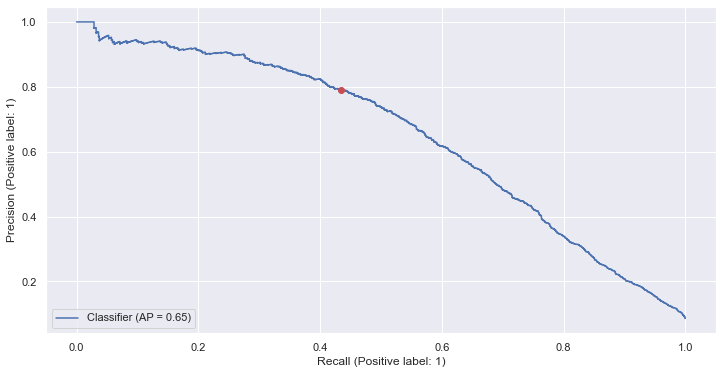

In [7]:
probs = pipe_XGB.predict_proba(X_test)[:,1]
PrecisionRecallDisplay.from_predictions(y_test, probs)
plt.plot(recall,precision,'ro');

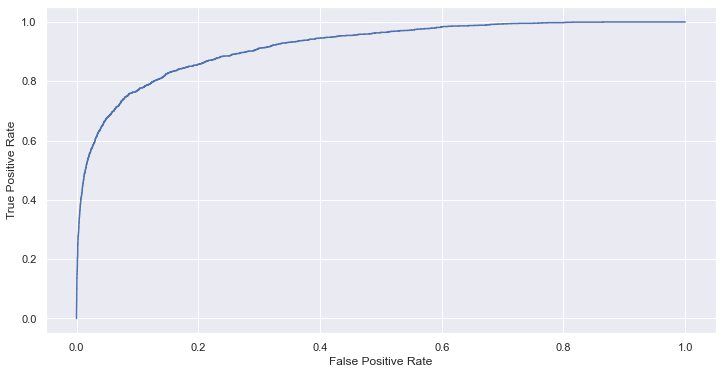

In [8]:
fpr, tpr, thresholds = roc_curve(y_test, probs, pos_label = 1)
disp = RocCurveDisplay(fpr = fpr, tpr = tpr)
disp.plot()

Text(0.5, 1.0, 'Feature Importance')

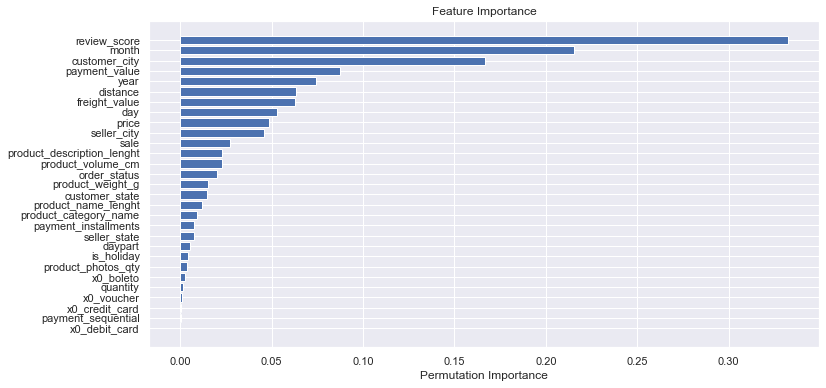

In [9]:
perm_importance = permutation_importance(pipe_XGB, X_test, y_test)

feature_names = X.columns
feat_imp = perm_importance.importances_mean
sorted_idx = feat_imp.argsort()
plt.barh(feature_names[sorted_idx], feat_imp[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance")

In [10]:
filename = '../model/XGBoost_stratified.sav'
pickle.dump(pipe_XGB, open(filename, 'wb'))

## Downsampling

In [11]:
rus = RandomUnderSampler(replacement=False, random_state=random_state)
X_dev_us, y_dev_us = rus.fit_resample(X_dev, y_dev)

### GridSearch

In [12]:
learning_rate = [0.05,0.1,0.15]
n_estimators = [100,200,300]
depth = [6,8,10]
start3 = time()

parameter_grid = {'classifier__n_estimators':n_estimators,'classifier__learning_rate': learning_rate,'classifier__max_depth':depth}
pipe_XGB_tune = Pipeline([('classifier',XGBClassifier(use_label_encoder=False, random_state=random_state))])
pipe_XGB = make_pipeline(GridSearchCV(pipe_XGB_tune,
                                      param_grid=parameter_grid,
                                      return_train_score=True,
                                      cv=StratifiedKFold(n_splits=10,shuffle=False),
                                      n_jobs=-1, 
                                      scoring=['recall','f1'],
                                      refit='f1'))
pipe_XGB.fit(X_dev_us, np.ravel(y_dev_us))
end3 = time()
print("XGBoost model takes " + str(end3-start3) + "seconds")
print("The performance of the XGBoost model on test data is ", pipe_XGB.score(X_test, y_test))
grid_search_XGB = pipe_XGB.named_steps["gridsearchcv"]
print(f"The XGBoost model Best hyperparameters is ", grid_search_XGB.best_params_)

[01:49:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost model takes 1100.163990020752seconds
The performance of the XGBoost model on test data is  0.42231075697211157
The XGBoost model Best hyperparameters is  {'classifier__learning_rate': 0.1, 'classifier__max_depth': 10, 'classifier__n_estimators': 300}


### Evaluate on the Test Set

In [13]:
XGB_prediction = pipe_XGB.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test,XGB_prediction)}')
print(f'Recall: {recall_score(y_test,XGB_prediction)}')
print(f'Precision: {precision_score(y_test,XGB_prediction)}')
print(f'F-1 Score: {f1_score(y_test,XGB_prediction)}')

recall, precision = recall_score(y_test,XGB_prediction), precision_score(y_test,XGB_prediction)

Accuracy: 0.8307173433648982
Recall: 0.8209982788296041
Precision: 0.28426698450536353
F-1 Score: 0.42231075697211157


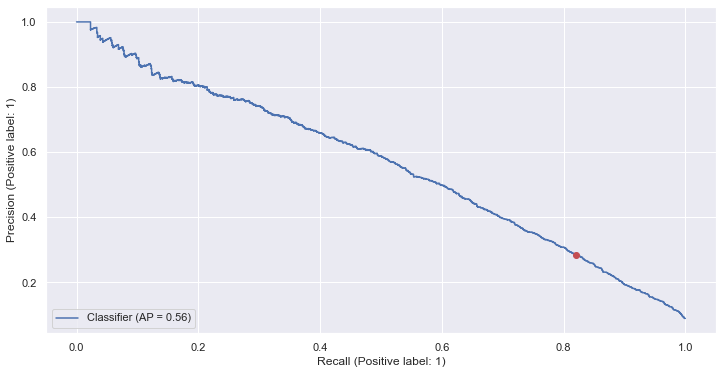

In [14]:
probs = pipe_XGB.predict_proba(X_test)[:,1]
PrecisionRecallDisplay.from_predictions(y_test, probs)
plt.plot(recall,precision,'ro');

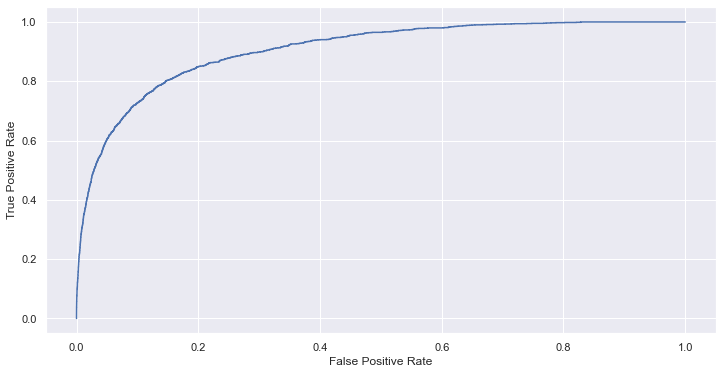

In [15]:
fpr, tpr, thresholds = roc_curve(y_test, probs, pos_label = 1)
disp = RocCurveDisplay(fpr = fpr, tpr = tpr)
disp.plot()

Text(0.5, 1.0, 'Feature Importance')

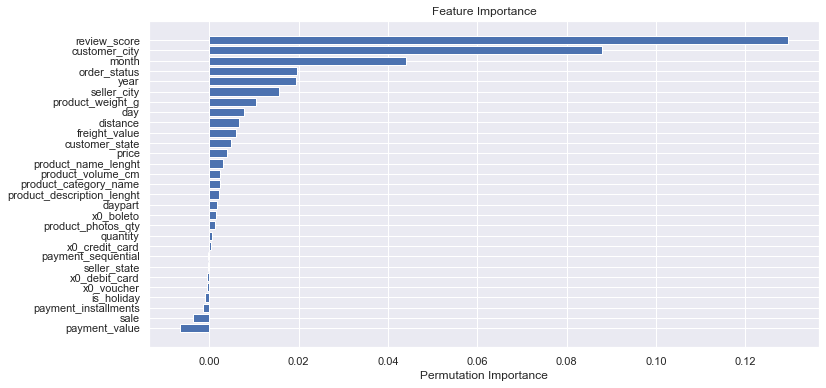

In [16]:
perm_importance = permutation_importance(pipe_XGB, X_test, y_test)

feature_names = X.columns
feat_imp = perm_importance.importances_mean
sorted_idx = feat_imp.argsort()
plt.barh(feature_names[sorted_idx], feat_imp[sorted_idx])
plt.xlabel("Permutation Importance")
plt.title("Feature Importance")

In [17]:
filename = '../Model/XGBoost_downsampling.sav'
pickle.dump(pipe_XGB, open(filename, 'wb'))

[00:28:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:30:36] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:32:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:35:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/Users/lukas/opt/anaconda3/envs/AML/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/lukas/opt/anaconda3/envs/AML/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/lukas/opt/anaconda3/envs/AML/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/lukas/opt/anaconda3/envs/AML/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int6

 eval_metric if you'd like to restore the old behavior.
[01:13:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:14:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:16:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:16:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explic

e removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/lukas/opt/anaconda3/envs/AML/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/lukas/opt/anaconda3/envs/AML/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/lukas/opt/anaconda3/envs/AML/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype inst

[00:28:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:30:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:34:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:36:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/Users/lukas/opt/anaconda3/envs/AML/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/lukas/opt/anaconda3/envs/AML/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/lukas/opt/anaconda3/envs/AML/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/lukas/opt/anaconda3/envs/AML/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int6

[00:28:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:30:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:34:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:36:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/Users/lukas/opt/anaconda3/envs/AML/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/lukas/opt/anaconda3/envs/AML/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/lukas/opt/anaconda3/envs/AML/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/lukas/opt/anaconda3/envs/AML/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int6

[00:28:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:30:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:34:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:36:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/Users/lukas/opt/anaconda3/envs/AML/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/lukas/opt/anaconda3/envs/AML/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/lukas/opt/anaconda3/envs/AML/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/lukas/opt/anaconda3/envs/AML/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int6

[00:28:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:30:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:32:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:35:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/Users/lukas/opt/anaconda3/envs/AML/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/lukas/opt/anaconda3/envs/AML/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/lukas/opt/anaconda3/envs/AML/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/lukas/opt/anaconda3/envs/AML/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int6

[00:28:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:30:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:34:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:36:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/Users/lukas/opt/anaconda3/envs/AML/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/lukas/opt/anaconda3/envs/AML/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/lukas/opt/anaconda3/envs/AML/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/lukas/opt/anaconda3/envs/AML/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int6